In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.ion()

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = 14 

In [3]:
import dask.dataframe as dd
# from dask.diagnostics import ProgressBar
# from dask.distributed import Client, progress

In [4]:
# client = Client()

In [5]:
# client

In [51]:
df = dd.read_csv("../data/dat_two_years.csv")

In [52]:
df.head()

,station_id,_col1,num_bikes_available
0,3188,2017-10-13 05:00:12.000,0
1,3188,2017-10-13 05:04:11.000,0
2,3188,2017-10-13 05:12:08.000,0
3,3188,2017-10-13 05:20:19.000,0
4,3188,2017-10-13 05:32:14.000,0


In [53]:
df.columns = ["station_id", "last_reported", "num_bikes_available"]

In [66]:
a_station = df[df.station_id == 3744].compute()

In [69]:
a_station.last_reported.unique()

array(['1969-12-31 19:00:00.000'], dtype=object)

In [39]:
# a_station[a_station.last_reported == "1969-12-31 19:00:00.000"]

In [55]:
tmp = a_station.copy()

In [56]:
tmp["last_reported"] = pd.to_datetime(tmp["last_reported"])
a_station["last_reported"] = pd.to_datetime(a_station["last_reported"])


In [58]:
tmp[tmp["last_reported"] < "2016-01-01"]["last_reported"].unique()

array(['1970-01-01T05:00:01.000000000', '1969-12-31T19:00:00.000000000'],
      dtype='datetime64[ns]')

In [59]:
tmp = tmp[tmp.last_reported >= "2016-01-01"]

In [60]:
a_station = a_station.set_index("last_reported").sort_index()
tmp = tmp.set_index("last_reported").sort_index()

In [61]:
len(a_station)

484744

In [62]:
len(tmp)

478177

In [63]:
# TODO: write tests for this

a_station = a_station.resample("5T", label="right", closed="right").last().fillna(method="ffill")
tmp = tmp.resample("5T", label="right", closed="right").last().fillna(method="ffill")

In [64]:
len(tmp)

198265

In [65]:
len(a_station)

5213590

In [50]:
tmp.head()

,station_id,num_bikes_available
last_reported,,
1970-01-01 05:05:00,524.0,0.0
1970-01-01 05:10:00,524.0,0.0
1970-01-01 05:15:00,524.0,0.0
1970-01-01 05:20:00,524.0,0.0
1970-01-01 05:25:00,524.0,0.0


In [13]:
from skits.preprocessing import HorizonTransformer
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import FeatureUnion

from skits.feature_extraction import AutoregressiveTransformer
from skits.pipeline import ForecasterPipeline
from skits.preprocessing import ReversibleImputer


period_minutes = 5
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)



In [14]:
y = a_station.num_bikes_available.values.copy()
X = y.reshape(-1, 1).copy()

In [15]:
# from xgboost import XGBRegressor


# xgb_pipeline = ForecasterPipeline([
#     # Convert the `y` target into a horizon
#     ('pre_horizon', HorizonTransformer(horizon=samples_per_hour * 2)),
#     ('pre_reversible_imputer', ReversibleImputer(y_only=True)),
#     ('features', FeatureUnion([
#         # Generate a week's worth of autoregressive features
#         ('ar_features', AutoregressiveTransformer(num_lags=samples_per_week)),
#     ])),
#     ('post_feature_imputer', ReversibleImputer()),
#     ('regressor', MultiOutputRegressor(XGBRegressor(n_jobs=12, 
#                                                     n_estimators=300)))
# ])

# xgb_pipeline = xgb_pipeline.fit(X, y)

In [15]:
pipeline = ForecasterPipeline([
    # Convert the `y` target into a horizon
    ('pre_horizon', HorizonTransformer(horizon=samples_per_hour * 2)),
    ('pre_reversible_imputer', ReversibleImputer(y_only=True)),
    ('features', FeatureUnion([
        # Generate a week's worth of autoregressive features
        ('ar_features', AutoregressiveTransformer(num_lags=samples_per_week)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', LinearRegression(n_jobs=-1))
])

pipeline = pipeline.fit(X, y)

/Users/er/anaconda3/envs/citi_bikecaster_xgboost/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [16]:
import pickle

with open("station_453.pkl", "wb") as f:
    pickle.dump(pipeline, f)


In [24]:
test_size = 2000

pred = pipeline.predict(X, start_idx=len(X) - test_size)

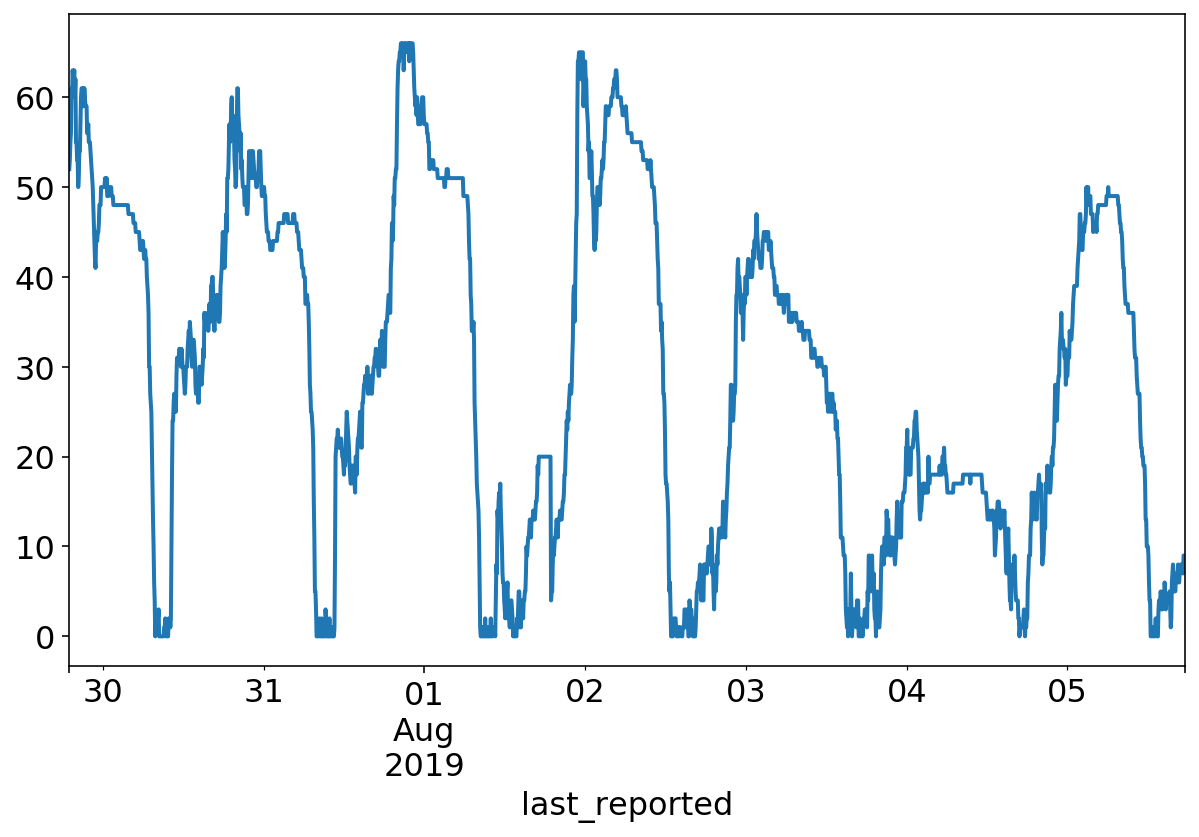

In [25]:
a_station["num_bikes_available"].iloc[-test_size:].plot();

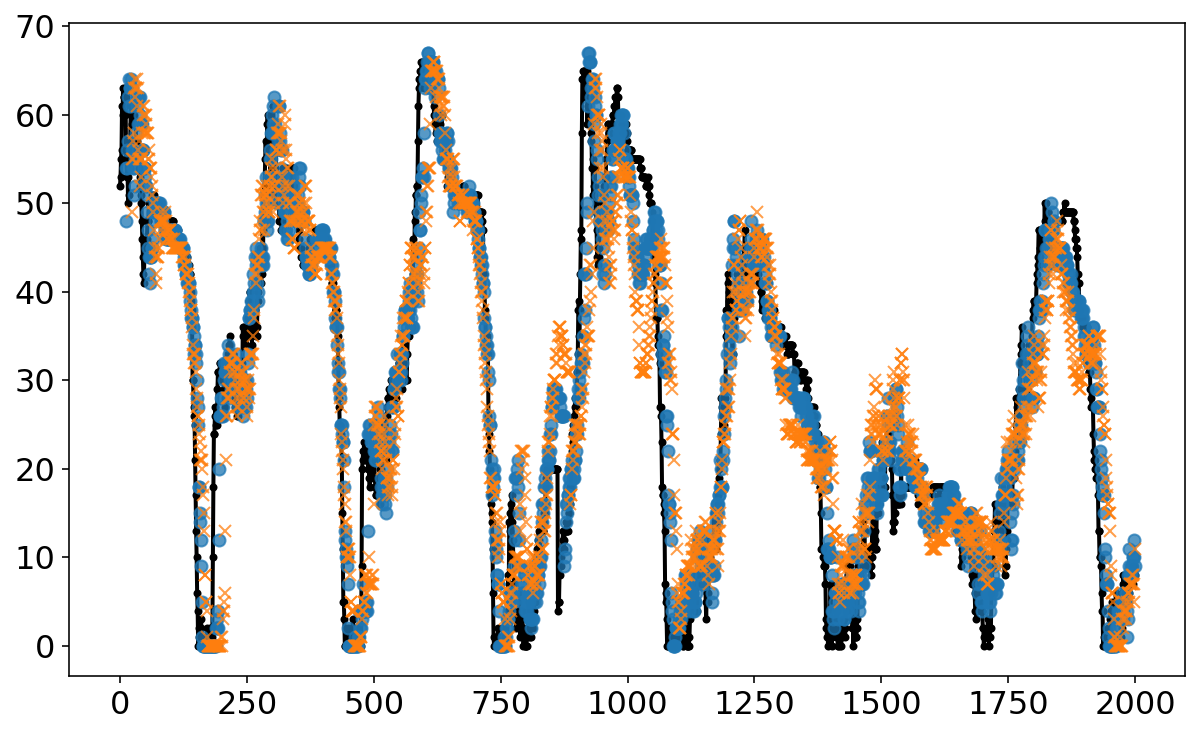

In [28]:

plt.plot(y[-test_size:], 'k.-');
plt.plot(np.arange(11, test_size), np.clip(np.round(pred[:-11, 11]), 0, None), 'o', alpha=0.75);
plt.plot(np.arange(23, test_size), np.clip(np.round(pred[:-23, 23]), 0, None), 'x', alpha=0.75);
